# All-e market research
This notebook contains the data analysis for the all-e market research.  

## contents
1) Loading daily aggregated data from Clickhouse / local.
2) Fitting a heat demand vs. ambiant temperature model per cic.
3) Fitting a water temp vs. ambiant temperature model per cic.
4) Extrapolating both to make a plot at -10, -5 and 0 degrees for each cic.
5) Plotting in the same figure the maximum available heat production.


to do:
- filter out cic's with more than 10 missing days (cic swaps?)
- check filtering of outliers, especially for water supply model
- check if we can filter out houses in a certain way
- is there a way to make sure that we are looking an accurate representation?
- is 5kWh going to make a significant impact?

In [1]:
import clickhouse_connect
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import os
from os import path
from plotly import colors
import plotly.express as px 
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.linear_model import TheilSenRegressor, LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


# PLotting theme
pio.templates.default = "plotly_white"

In [2]:
# Load username and password from .env file
env_path = Path('../') / '.env'
load_dotenv(env_path)

True

## 2) data cleaning and definition of models

In [3]:
def heat_demand_model(Ta, c0, c1):
    return c0 * Ta + c1

## 1) Load daily aggregated data from clickhouse

In [4]:
# Set up Clickhouse client
HOST_CH = os.getenv("HOST_CH")
USERNAME_CH = os.getenv("USERNAME_CH")
PASSWORD_CH = os.getenv("PASSWORD_CH")
client = clickhouse_connect.get_client(host=HOST_CH, port=8443, username=USERNAME_CH, password=PASSWORD_CH)

del HOST_CH, USERNAME_CH, PASSWORD_CH


Unexpected Http Driver Exception


OperationalError: Error HTTPSConnectionPool(host='qw8ll5b5bw.eu-west-1.aws.clickhouse.cloud', port=8443): Max retries exceeded with url: /?wait_end_of_query=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x2834a7850>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')) executing HTTP request attempt 1 https://qw8ll5b5bw.eu-west-1.aws.clickhouse.cloud:8443

In [5]:
# Get data from a 100 CiCs
LOAD_LOCAL_DATA = True
SAVE_LOCAL_DATA = True

i=0

filename = 'CH_data_3hr_{}.csv'
filepath = path.join(os.getcwd(), 'data', filename)

if LOAD_LOCAL_DATA:
    df_cics = pd.read_csv(filepath.format('all'))
else:
    sql_get_cic_ids = """
    WITH cic_ids AS (
        SELECT
            clientid,
            ifNull(max(qc_houseEnergyCounter) - min(qc_houseEnergyCounter), 0) AS Q_house
        FROM "{cic_stats_table}"
        WHERE
            time_ts >= '{start_date}'
        GROUP BY
            clientid
        ORDER BY
            Q_house DESC
        LIMIT {num_cics} OFFSET {offset}
    ),
    hourly_values AS (
        SELECT
            clientid,
            toStartOfHour(time_ts) AS h,
            avg(hp1_temperatureOutside) as ambientTemperature,
            avgIf(flowMeter_waterSupplyTemperature, 
                qc_supervisoryControlMode IN (2, 3, 4)
            ) as supplyTemperature,
            avg(qc_supervisoryControlMode IN (2, 3, 4)) as system_on,
            avgIf(greatest(
                    coalesce(hp1_watchdogCode=9,0),
                    coalesce(hp2_watchdogCode=9,0)
                ), 
                qc_supervisoryControlMode IN (2,3,4)
            ) as supplyTemperatureOos,
            avg(thermostat_otFtRoomSetpoint - thermostat_otFtRoomTemperature) as roomTemperatureError,
            avg(thermostat_otFtRoomSetpoint) as roomSetTemperature,
            avg(thermostat_otFtRoomTemperature) as roomTemperature,
            ifNull(argMax(hp1_thermalEnergyCounter, time_ts) - argMin(hp1_thermalEnergyCounter, time_ts), 0)/1000 AS Q_hp1,
            ifNull(argMax(hp2_thermalEnergyCounter, time_ts) - argMin(hp2_thermalEnergyCounter, time_ts), 0)/1000 AS Q_hp2,
            ifNull(argMax(hp1_electricalEnergyCounter, time_ts) - argMin(hp1_electricalEnergyCounter, time_ts), 0)/1000 AS E_hp1,
            ifNull(argMax(hp2_electricalEnergyCounter, time_ts) - argMin(hp2_electricalEnergyCounter, time_ts), 0)/1000 AS E_hp2,
            Q_hp1 + Q_hp2 AS Q_hp,
            E_hp1 + E_hp2 AS E_hp,
            ifNull(argMax(qc_cvEnergyCounter, time_ts) - argMin(qc_cvEnergyCounter, time_ts), 0)/1000 AS Q_cv,
            Q_hp + Q_cv AS Q_house,
            (({cost_gas} / {calorific_value_gas} * (Q_hp)) - ({cost_electricity} * (E_hp))) AS savings,
            SUM(Q_hp) OVER w_3hr AS Q_hp_3hr,
            SUM(Q_hp1) OVER w_3hr AS Q_hp1_3hr,
            SUM(Q_hp2) OVER w_3hr AS Q_hp2_3hr,
            SUM(E_hp) OVER w_3hr AS E_hp_3hr,
            SUM(E_hp1) OVER w_3hr AS E_hp1_3hr,
            SUM(E_hp2) OVER w_3hr AS E_hp2_3hr,
            SUM(Q_cv) OVER w_3hr AS Q_cv_3hr,
            SUM(Q_house) OVER w_3hr AS Q_house_3hr,
            Q_hp_3hr / Q_house_3hr as hpHeatRatio_3hr,
            Q_hp_3hr / E_hp_3hr as COP_3hr,
            AVG(supplyTemperature) OVER w_3hr AS supplyTemperature_3hr
        FROM
            "{cic_stats_table}"
        WHERE clientid IN (SELECT clientid FROM cic_ids)
            AND time_ts >= '{start_date}'
        GROUP BY
            clientid,
            h
        WINDOW w_3hr AS (
            PARTITION BY clientid
            ORDER BY h
            ROWS BETWEEN CURRENT ROW AND 2 FOLLOWING
        )
        ORDER BY
            clientid,
            h
    )
    SELECT clientid, toDate(h) as d, 
        avg(ambientTemperature) as ambientTemperature,
        avg(supplyTemperature) as supplyTemperature,
        avg(supplyTemperatureOos) as supplyTemperatureOos,
        avg(roomTemperatureError) as roomTemperatureError,
        avg(roomSetTemperature) as roomSetTemperature,
        avg(roomTemperature) as roomTemperature,
        sum(Q_hp) as Q_hp_24hr,
        sum(Q_hp1) as Q_hp1_24hr,
        sum(Q_hp2) as Q_hp2_24hr,
        sum(E_hp) as E_hp_24hr,
        sum(E_hp1) as E_hp1_24hr,
        sum(E_hp2) as E_hp2_24hr,
        sum(Q_cv) as Q_cv_24hr,
        sum(Q_house) as Q_house_24hr,
        Q_hp_24hr / Q_house_24hr as hpHeatRatio,
        Q_hp_24hr / E_hp_24hr as COP,
        argMax(h, Q_house_3hr) as h_3hr_max,
        max(Q_house_3hr) as Q_house_3hr_max,
        argMax(Q_hp_3hr, Q_house_3hr) as Q_hp_3hr_max,
        argMax(Q_hp1_3hr, Q_house_3hr) as Q_hp1_3hr_max,
        argMax(Q_hp2_3hr, Q_house_3hr) as Q_hp2_3hr_max,
        argMax(E_hp_3hr, Q_house_3hr) as E_hp_3hr_max,
        argMax(E_hp1_3hr, Q_house_3hr) as E_hp1_3hr_max,
        argMax(E_hp2_3hr, Q_house_3hr) as E_hp2_3hr_max,
        argMax(Q_cv_3hr, Q_house_3hr) as Q_cv_3hr_max,
        argMax(hpHeatRatio_3hr, Q_house_3hr) as hpHeatRatio_3hr_max,
        argMax(COP_3hr, Q_house_3hr) as COP_3hr_max,
        argMax(supplyTemperature_3hr, Q_house_3hr) as supplyTemperature_3hr_max
    FROM hourly_values
    GROUP BY clientid, toDate(h)
    HAVING Q_house_24hr > 3
    ORDER BY clientid, toDate(h)
    """

    # retrieve data in batches to avoid server side memory issues
    for i in range(0, 5):
        query_result = client.query_df(
            sql_get_cic_ids.format(
                        num_cics = 1000,
                        offset = i*1000,
                        start_date = '2023-08-01',
                        cic_stats_table = 'cic_stats',
                        calorific_value_gas = 8.8, # kWh/m3
                        cost_gas = 1.46, # €/m3
                        cost_electricity = 0.36 # €/kWh
            )
        )
        query_result.to_csv(filepath.format(i), index=False)
    
    # concatenate
    for i in range(0,5):
        block = pd.read_csv(filepath.format(i))
        if i==0:
            df_cics = block.copy()
        else:
            df_cics = pd.concat([df_cics, block])
    df_cics.to_csv(filepath.format('all'), index=False)



In [6]:
# get number of heat pumps per cic_id
# Get data from a 100 CiCs
LOAD_LOCAL_DATA = True
SAVE_LOCAL_DATA = True

filename = 'CH_nhps.csv'
filepath = path.join(os.getcwd(), 'data', filename)

if LOAD_LOCAL_DATA:
    df_nhps = pd.read_csv(filepath)
else:
    sql_get_nhps = """
    SELECT
        clientid,
        max(coalesce(system_ccNumberOfHeatPumps, 0)) as nhps
    FROM cic_stats
    WHERE time_ts > '2023-08-01'
    GROUP BY clientid
    order by nhps
    """

    df_nhps = client.query_df(sql_get_nhps)
    if SAVE_LOCAL_DATA:
        df_nhps.to_csv(filepath, index=False)



In [7]:
# Clean up and pre-process data

# rename clientid to cic_id
df_cics.rename(columns={'clientid': 'cic_id'}, inplace=True)
df_cics['dt'] = pd.to_datetime(df_cics['d'])

print(f"Number of CiCs: {len(df_cics['cic_id'].unique())}")
print(f"Number of rows: {len(df_cics.index)}")

# Remove outliers from Q_hp1, Q_hp2, E_hp1, E_hp2
max_Q_hp = 8 # kWh
max_E_hp = 3 # kWh
max_Q_cv = 37 # kWh

df_cics = df_cics[
    (df_cics['Q_hp1_24hr'] < 24 * max_Q_hp) & (df_cics['Q_hp2_24hr'] < 24 * max_Q_hp) & 
    (df_cics['E_hp1_24hr'] < 24 * max_E_hp) & (df_cics['E_hp2_24hr'] < 24 * max_E_hp) &
    (df_cics['Q_cv_24hr'] < 24 * max_Q_cv)
].copy()
print(f"Number of rows after removing 24hr outliers: {len(df_cics.index)}")

df_cics = df_cics[
    (df_cics['Q_hp1_3hr_max'] < 3 * max_Q_hp) & (df_cics['Q_hp2_3hr_max'] < 3 * max_Q_hp) & 
    (df_cics['E_hp1_3hr_max'] < 3 * max_E_hp) & (df_cics['E_hp2_3hr_max'] < 3 * max_E_hp) &
    (df_cics['Q_cv_3hr_max'] < 3 * max_Q_cv)
].copy()
print(f"Number of rows after removing 3hr outliers: {len(df_cics.index)}")

# Remove days when CiC was in LTE mode
df_cics.dropna(subset=['ambientTemperature', 'supplyTemperature', 'roomTemperatureError', 'roomSetTemperature', 'roomTemperature'], inplace=True)
print(f"Number of rows after removing days when CiC was in LTE mode: {len(df_cics.index)}")

# remove rows with extremely low temperature measurement
df_cics = df_cics[df_cics['ambientTemperature']>-5]
print(f"Number of rows after removing rows when ambientTemperature < -5: {len(df_cics.index)}")

# Remove rows of cic's that have less than 10 days of data
df_cics = df_cics.groupby('cic_id').filter(lambda x: len(x.index) >= 10)
print(f"Number of rows after removing cic's with less than 10 days of data: {len(df_cics.index)}")

# Remove rows of cic's that have data only after 2023-11-23
df_cics = df_cics.groupby('cic_id').filter(lambda x: min(x.dt) <= pd.to_datetime('2023-11-26'))
print(f"Number of rows after removing cic's with no data before 2023-11-26: {len(df_cics.index)}")
print(f"Number of cics: {len(df_cics['cic_id'].unique())}")



Number of CiCs: 4852
Number of rows: 353038
Number of rows after removing 24hr outliers: 351197
Number of rows after removing 3hr outliers: 348817
Number of rows after removing days when CiC was in LTE mode: 335006
Number of rows after removing rows when ambientTemperature < -5: 334887
Number of rows after removing cic's with less than 10 days of data: 334654
Number of rows after removing cic's with no data before 2023-11-26: 322787
Number of cics: 4311


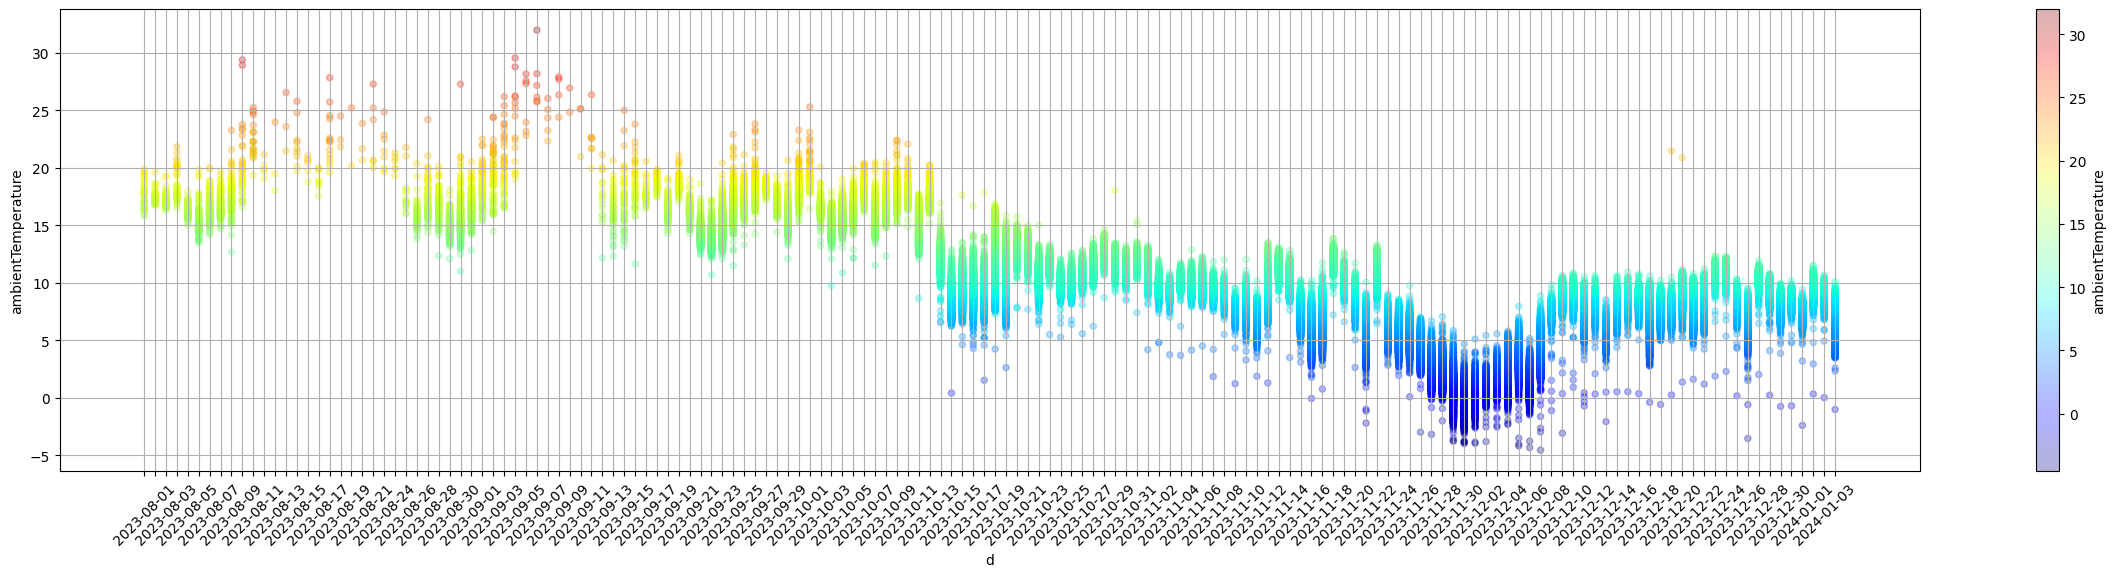

In [8]:
# df_cics['dm'] = df_cics['d'].dt.strftime('%m-%d')
df_cics.sort_values(by='d', inplace=True)
ax = df_cics.plot(kind='scatter', y='ambientTemperature', x='d', figsize=[30, 6], c='ambientTemperature', cmap='jet', rot=45, alpha=0.3, grid=True)

# Customizing to show every other label
labels = ax.get_xticklabels()
for i, label in enumerate(labels):
    if i % 2 != 0:  # Hide every other label
        label.set_visible(False)

plt.show()

In [8]:
def fit_model(df, x_col, y_col):
    model = TheilSenRegressor(random_state=0)
    
    if len(df.index) >= 10:
        X = df[x_col].to_numpy().reshape(-1, 1)
        y = df[y_col].to_numpy()
        model.fit(X, y)
        rmse = mean_squared_error(y, model.predict(X), squared=False)
        score = model.score(X, y)
        
        return model.coef_[0], model.intercept_, rmse, len(df), score
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan



# Define the cic_ids and column pairs
cic_ids = df_cics['cic_id'].unique()
# cic_ids = random.sample(df_cics['cic_id'].unique().tolist(), 1000)
# take a random sample of 100 cic's out of cic_ids

model_list = [{'colname': 'supplyTemperature', 'name':'WaterTemp_24hr'},
              {'colname': 'Q_house_24hr', 'name':'Q_house_24hr'},
            #   {'colname': 'supplyTemperature_3hr_max', 'name':'WaterTemp_3hr_filt', 'filter':'ambientTemperature<7'},
              {'colname': 'supplyTemperature_3hr_max', 'name':'WaterTemp_3hr'},
              {'colname': 'Q_house_3hr_max', 'name':'Q_house_3hr'}]

metrics = ['slope', 'intercept', 'rmse', 'n', 'R2']

# create dataframe for models
df_cic_models_columns = ['cic_id'] + [f'{model["name"]}_{metric}' for model in model_list for metric in metrics]
df_cic_models = pd.DataFrame(columns=df_cic_models_columns)
df_cic_models['cic_id'] = cic_ids

# create dataframe for results
df_results = pd.DataFrame(columns=['cic_id',*[model['name'] for model in model_list]])
df_results['cic_id'] = cic_ids


# train models
for cic in cic_ids:
    df_cic = df_cics[df_cics['cic_id']==cic]

    for model in model_list:
        if 'filter' in model:
            slope, intercept, rmse, n, score = fit_model(df_cic.query(model['filter']),
                                                  'ambientTemperature',
                                                  model['colname'])
        else:
            slope, intercept, rmse, n, score = fit_model(df_cic,
                                                  'ambientTemperature', 
                                                  model['colname'])

        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_slope'] = slope
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_intercept'] = intercept
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_rmse'] = rmse
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_n'] = n
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_R2'] = score

In [9]:
df_cic_models = df_cic_models.apply(pd.to_numeric, errors='ignore')

## Extrapolate to -7 degrees

From [google sheet](https://docs.google.com/spreadsheets/d/15kTyQeI37S-ABCxKRoklAmAvpKCPe6Ss/edit#gid=177825386).  
At -7 degrees, for a 4kW unit:  
- supplyTemperature = 35, Pmax = 4.748 (90 Hz), Qmax = 113.952
- supplyTemperature = 45, Pmax = 3.627 (90 Hz), Qmax = 87.048
- supplyTemperature = 55, Pmax = 3.360 (84 Hz), Qmax = 80.64
- electricalHeater of boiler of 2kW -> Qmax += 48

At -7 degrees, for an 8kW unit:
- supplyTemperature = 35, Pmax = 8.375 = 3.980 + 4.748 (79 Hz & 90 Hz), Qmax = 201
- supplyTemperature = 45, Pmax = 6.739 = 3.11 + 3.627 (79Hz & 90 Hz), Qmax = 161.75
- supplyTemperature = 55, Pmax = 6.40 = 3.04 * 3.360 (79Hz & 84 Hz), Qmax = 153.62
- electricalHeater of boiler of 2kW -> Qmax += 48


single_hybrid_limits = [4.748, 3.627, 3.360]
double_hybrid_limits = [8.375, 6.739, 6.40]

In [10]:
# calculate heat demand and water supply temperature for each cic
target_temperature = -7

df_results = pd.DataFrame(columns=['cic_id',*[model['name'] for model in model_list]])
df_results['cic_id'] = cic_ids

# only cic's where heat demand goes up as temperature goes down
# df_results['cic_id'] = df_cics_train[(df_cics_train['heat_slope']<0) & (df_cics_train['water_slope'].notna())]['cic_id'].unique()

# predict target temperature
for model in model_list:
    df_results[model['name']] = df_results['cic_id'].apply(
        lambda x: heat_demand_model(target_temperature,
                                    df_cic_models[df_cic_models['cic_id'] == x][f'{model["name"]}_slope'].values[0],
                                    df_cic_models[df_cic_models['cic_id'] == x][f'{model["name"]}_intercept'].values[0]))

df_merged = pd.merge(df_results, df_cic_models, on='cic_id', how='left')

In [11]:
# replace linear models with negative slope with their mean + 2*std (for watersupplyTemperature 3hr)
df_mean_std = df_cics.groupby('cic_id')['supplyTemperature_3hr_max'].mean() + 2 * df_cics.groupby('cic_id')['supplyTemperature_3hr_max'].std()

df_merged = df_merged.merge(df_mean_std, on='cic_id', how='left')

# replace linear models with negative slope with their mean + 2*std (for watersupplyTemperature 3hr)
df_merged.loc[df_merged['WaterTemp_3hr_slope']>0, 'WaterTemp_3hr'] = df_merged.loc[df_merged['WaterTemp_3hr_slope']>0, 'supplyTemperature_3hr_max']

In [35]:
# heat pump limits at -7 degrees ambiant
lwt = limit_water_temps =    [20,     35,      45,      55] # deg. Celcius
shl = single_hybrid_limits = [4.748,  4.748,   3.627,   3.360] #kW
hdl = hybrid_duo_limits =    [8.375,  8.375,   6.739,   6.40] #kW

boost = 2.5 #kW
electric_element = 2 #kW

# single including boost
shl_wb = [x + boost for x in shl]
shl_wb_we = [x + boost + electric_element for x in shl]
shl_we = [x + electric_element for x in shl]

# hybrid duo including boost and element
hdl_wb =[x + boost for x in hdl]
hdl_wb_we = [x + boost + electric_element for x in hdl]
hdl_we = [x + electric_element for x in hdl]

def make_polygon(pol):
    pol['x'] = [*pol['lwt'], *pol['lwt'][::-1]]
    pol['y'] = [x * pol['hrs'] for x in [*pol['upper_bound'], *pol['lower_bound'][::-1]]]

    return pol

# create a function that checks whether a point is inside a polygon
def point_in_polygon(point, polygon):
    return Polygon(polygon).contains_point(point)

# define plotting function
def plot_results(df_results, polygons, title, xcol, ycol, shortname):
    
    # attach color and id to df_results
    df_results[f'{shortname}_colors'] = df_results.apply(
        lambda row: next((polygon['color'] for polygon in polygons 
                          if point_in_polygon((row[xcol], row[ycol]), 
                                              list(zip(polygon['x'], polygon['y'])))), 
                                              None), axis=1)
    df_results[f'{shortname}_id'] = df_results.apply(
        lambda row: next((polygon['id'] for polygon in polygons 
                          if point_in_polygon((row[xcol], row[ycol]), 
                                              list(zip(polygon['x'], polygon['y'])))), 
                                              None), axis=1)
    
    df_results[df_results[f'{shortname}_colors'].notna()].plot(
        kind='scatter', x=xcol, y=ycol, 
        alpha=0.2, 
        c=df_results[df_results[f'{shortname}_colors'].notna()][f'{shortname}_colors'].tolist(),
        # c = df_results[df_results[f'{shortname}_colors'].notna()]['WaterTemp_3hr_R2'], cmap='jet',
        figsize=(10, 6)
    )

    for polygon in polygons:
        points_in_polygon = df_results.apply(
            lambda row: point_in_polygon((row[xcol], row[ycol]), list(zip(polygon['x'], polygon['y']))), axis=1)
        percentage = points_in_polygon.sum() / len(df_results) * 100
        if polygon['id']==12:
            labelx = 65
        else:
            labelx = sum(polygon['x'])/len(polygon['x'])
        if polygon['id']==12:
            labely = 2 * polygons[0]['hrs']
        elif polygon['id']==11:
            labely = 15 * polygons[0]['hrs']
        else:
            labely = sum(polygon['y'])/len(polygon['y'])

        plt.text(labelx, 
                 labely, 
                 f'{polygon["label"]}: {percentage:.1f}%', 
                 horizontalalignment='center', 
                 verticalalignment='center')

    # lines seperating different polygons
    plt.plot([55, 55], [0, polygons[0]['y'][5]], color='grey', label='55 degrees',linewidth=0.2, linestyle='--')
    # plt.axvline(x=55, color='grey', label='55 degrees',linewidth=1)

    plt.plot(polygons[0]['x'][:5], polygons[0]['y'][:5], color=polygons[0]['color'], 
             linestyle='--', label=polygons[0]['label'])
    plt.plot(polygons[1]['x'][:5], polygons[1]['y'][:5], color=polygons[1]['color'], 
             linestyle='--', label=polygons[1]['label'])
    plt.plot(polygons[2]['x'][:5], polygons[2]['y'][:5], color=polygons[2]['color'], 
             linestyle='--', label=polygons[2]['label'])
    plt.plot(polygons[-1]['x'][:3], polygons[-1]['y'][:3], color=polygons[-1]['color'], 
             linestyle='--', label=polygons[-1]['label'])


    plt.title(title)
    plt.xlabel('Supply temperature')
    plt.xlim(20, 80)
    plt.ylim(0, 20*polygons[0]['hrs'])
    plt.ylabel('Heat demand')
    # plt.grid()


    ax = plt.gca()
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')
    ax.spines[['bottom','left','right','top']].set_color('grey')

    # add legend
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)

    plt.show()

    return df_results





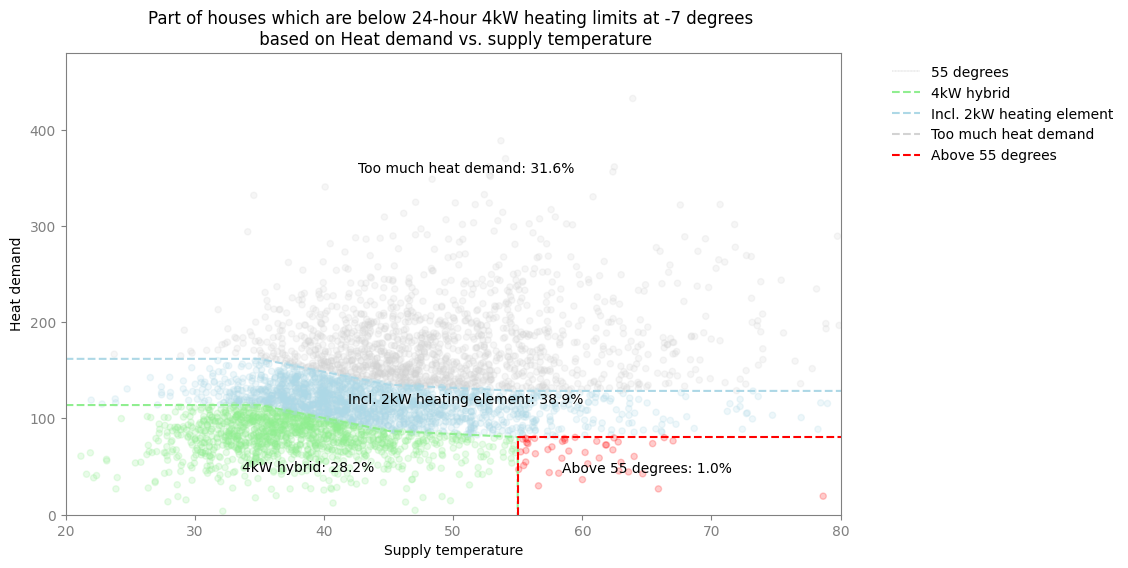

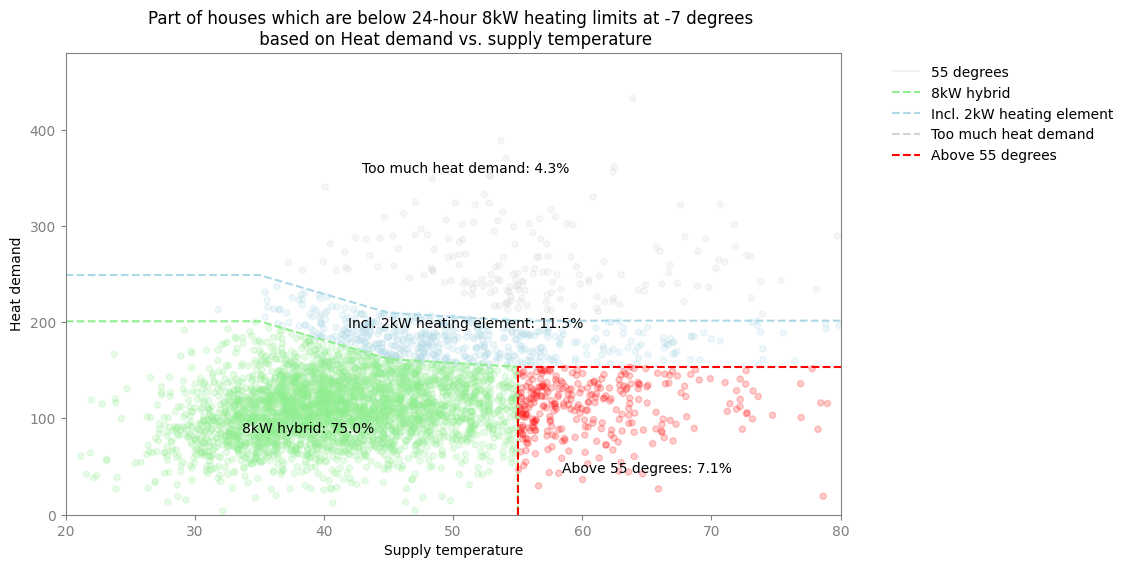

In [36]:
# 24hr hybrid single plot
hrs = 24

polygons_24_hr_single = [
    {'label': '4kW hybrid', 'color': 'lightgreen', 'id': 1, 'hrs': 24,
     'lwt':lwt, 'lower_bound': [0, 0, 0, 0], 'upper_bound': shl},
    {'label': 'Incl. 2kW heating element', 'color': 'lightblue', 'id': 2,'hrs': 24,
     'lwt':[*lwt, 100], 'lower_bound': [*shl,shl[-1]], 'upper_bound': [*shl_we, shl_we[-1]]},
    {'label': 'Too much heat demand', 'color': 'lightgrey', 'id':11, 'hrs':24,
     'lwt':[*lwt, 100], 'lower_bound': [*shl_we, shl_we[-1]], 'upper_bound': [200, 200, 200, 200, 200]}
]
for pol in polygons_24_hr_single:
    pol = make_polygon(pol)
polygons_24_hr_single.append({'label': 'Above 55 degrees', 'color': 'red','x':[55, 55, 100, 100], 'y': [0, hrs*shl[-1], hrs*shl[-1], 0],   'id': 12})

df_merged = plot_results(df_merged, polygons_24_hr_single, 
                          'Part of houses which are below 24-hour 4kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature', 
                            'WaterTemp_24hr', 'Q_house_24hr', '24single')

# 24hr hybrid duo plot
# set up polygons
polygons_24_hr_duo = [
    {'label': '8kW hybrid', 'color': 'lightgreen', 'id': 1, 'hrs': 24,
     'lwt':lwt, 'lower_bound': [0, 0, 0, 0], 'upper_bound': hdl},
    {'label': 'Incl. 2kW heating element', 'color': 'lightblue', 'id': 2,'hrs': 24,
     'lwt':[*lwt, 100], 'lower_bound': [*hdl, hdl[-1]], 'upper_bound': [*hdl_we, hdl_we[-1]]},
    {'label': 'Too much heat demand', 'color': 'lightgrey', 'id':11, 'hrs':24,
     'lwt':[*lwt, 100], 'lower_bound': [*hdl_we, hdl_we[-1]], 'upper_bound': [200, 200, 200, 200]}
]
for pol in polygons_24_hr_duo:
    pol = make_polygon(pol)
polygons_24_hr_duo.append({'label': 'Above 55 degrees', 'color': 'red','x':[55, 55, 100, 100], 'y': [0, hrs*hdl[-1], hrs*hdl[-1], 0],   'id': 12})

df_merged = plot_results(df_merged, polygons_24_hr_duo, 
                          'Part of houses which are below 24-hour 8kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature', 
                            'WaterTemp_24hr', 'Q_house_24hr', '24duo')

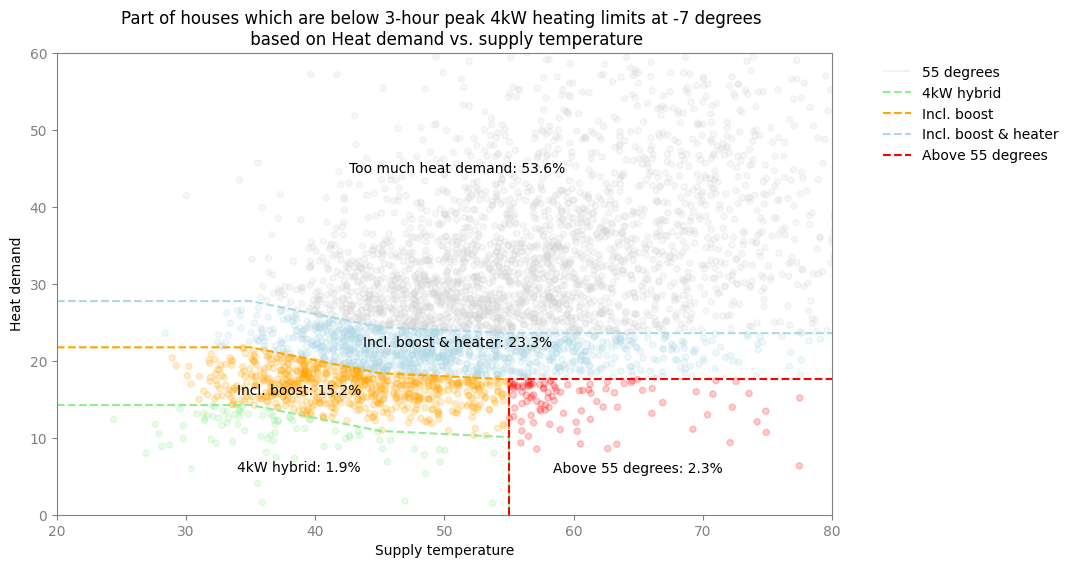

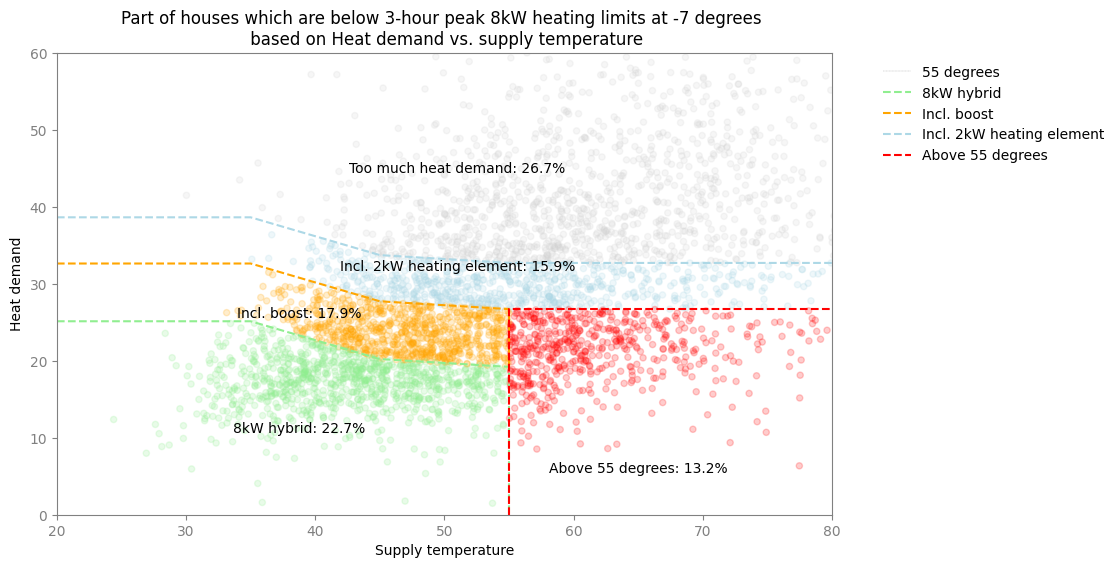

In [38]:
# 24hr hybrid single plot
hrs = 3

polygons_3_hr_single = [
    {'label': '4kW hybrid', 'color': 'lightgreen', 'id': 1, 'hrs': 3,
     'lwt':lwt, 'lower_bound': [0, 0, 0, 0], 'upper_bound': shl},
    {'label': 'Incl. boost', 'color': 'orange', 'id': 3, 'hrs': 3,
     'lwt':lwt, 'lower_bound': shl, 'upper_bound': shl_wb},
    {'label': 'Incl. boost & heater', 'color': 'lightblue', 'id': 4,'hrs': 3,
     'lwt':[*lwt, 100], 'lower_bound': [*shl_wb, shl_wb[-1]], 'upper_bound': [*shl_wb_we, shl_wb_we[-1]]},
    {'label': 'Too much heat demand', 'color': 'lightgrey', 'id':11, 'hrs':3,
     'lwt':[*lwt, 100], 'lower_bound': [*shl_wb_we, shl_wb_we[-1]], 'upper_bound': [20, 20, 20, 20, 20]}
]
for pol in polygons_3_hr_single:
    pol = make_polygon(pol)
polygons_3_hr_single.append({'label': 'Above 55 degrees', 'color': 'red','x':[55, 55, 100, 100], 'y': [0, hrs*shl_wb[-1], hrs*shl_wb[-1], 0],   'id': 12})

df_merged = plot_results(df_merged, polygons_3_hr_single, 
                          'Part of houses which are below 3-hour peak 4kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature', 
                            'WaterTemp_3hr', 'Q_house_3hr', '3single')

# 24hr hybrid duo plot
# set up polygons
polygons_3_hr_duo = [
    {'label': '8kW hybrid', 'color': 'lightgreen', 'id': 1, 'hrs': 3,
     'lwt':lwt, 'lower_bound': [0, 0, 0, 0], 'upper_bound': hdl},
     {'label': 'Incl. boost', 'color': 'orange', 'id': 3, 'hrs': 3,
     'lwt':lwt, 'lower_bound': hdl, 'upper_bound': hdl_wb},
    {'label': 'Incl. 2kW heating element', 'color': 'lightblue', 'id': 4,'hrs': 3,
     'lwt':[*lwt, 100], 'lower_bound': [*hdl_wb, hdl_wb[-1]], 'upper_bound': [*hdl_wb_we, hdl_wb_we[-1]]},
    {'label': 'Too much heat demand', 'color': 'lightgrey', 'id':11, 'hrs':3,
     'lwt':[*lwt, 100], 'lower_bound': [*hdl_wb_we, hdl_wb_we[-1]], 'upper_bound': [20, 20, 20, 20, 20]}
]
for pol in polygons_3_hr_duo:
    pol = make_polygon(pol)
polygons_3_hr_duo.append({'label': 'Above 55 degrees', 'color': 'red','x':[55, 55, 100, 100], 'y': [0, hrs*hdl_wb[-1], hrs*hdl_wb[-1], 0],   'id': 12})

df_merged = plot_results(df_merged, polygons_3_hr_duo, 
                          'Part of houses which are below 3-hour peak 8kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature', 
                            'WaterTemp_3hr', 'Q_house_3hr', '3duo')

## sankey diagram

In [44]:
# merge number of heat pumps onto df_merged
df_merged = df_merged.merge(df_nhps, left_on='cic_id', right_on='clientid', how='left')

In [46]:
df_merged.columns

Index(['cic_id', 'WaterTemp_24hr', 'Q_house_24hr', 'WaterTemp_3hr',
       'Q_house_3hr', 'WaterTemp_24hr_slope', 'WaterTemp_24hr_intercept',
       'WaterTemp_24hr_rmse', 'WaterTemp_24hr_n', 'WaterTemp_24hr_R2',
       'Q_house_24hr_slope', 'Q_house_24hr_intercept', 'Q_house_24hr_rmse',
       'Q_house_24hr_n', 'Q_house_24hr_R2', 'WaterTemp_3hr_slope',
       'WaterTemp_3hr_intercept', 'WaterTemp_3hr_rmse', 'WaterTemp_3hr_n',
       'WaterTemp_3hr_R2', 'Q_house_3hr_slope', 'Q_house_3hr_intercept',
       'Q_house_3hr_rmse', 'Q_house_3hr_n', 'Q_house_3hr_R2',
       'supplyTemperature_3hr_max', '24single_colors', '24single_id',
       '24duo_colors', '24duo_id', '3single_colors', '3single_id',
       '3duo_colors', '3duo_id', 'clientid_x', 'nhps_x', 'clientid_y',
       'nhps_y', 'clientid', 'nhps'],
      dtype='object')

In [59]:
# ids: 1=hp, 2=heater, 3=boost, 4=heater+boost, 11=Q overload, 12=>55 degrees
# test: 24single_id, 24duo_id, 3single_id, 3duo_id

n_4kw = len(df_merged[df_merged['nhps']==1])

# 4kws possible
n_4kw_p = len(df_merged[(df_merged['nhps']==1) &
                        (df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))
                          ])
n_4kw_p_wB = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3single_id'].isin([3])) & (df_merged['24single_id'].isin([1])))
                          ])
n_4kw_p_nB = len(df_merged[(df_merged['nhps']==1) &
                         ((df_merged['3single_id'].isin([1])) & (df_merged['24single_id'].isin([1])))
                          ])

# 4kw possible if they change to 8kw
n_4kw_m = len(df_merged[(df_merged['nhps']==1) &
                        ~((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))) & # not already possible with one
                         ((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1])))
                          ])
n_4kw_m_wB = len(df_merged[(df_merged['nhps']==1) &
                         ~((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))) & # not already possible with one
                         ((df_merged['3duo_id'].isin([3])) & (df_merged['24duo_id'].isin([1])))
                          ])
n_4kw_m_nB = len(df_merged[(df_merged['nhps']==1) &
                        ~((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))) & # not already possible with one
                         ((df_merged['3duo_id'].isin([1])) & (df_merged['24duo_id'].isin([1])))
                          ])

# 4kws not possible
n_4kw_np = len(df_merged[(df_merged['nhps']==1) &
                          ~((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))) & # not already possible with one
                          ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) # neither with two
                          ])
n_4kw_np_Q = len(df_merged[(df_merged['nhps']==1) &
                           ~((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged['3duo_id'].isin([4,11])) | (df_merged['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_4kw_np_T = len(df_merged[(df_merged['nhps']==1) &
                           ~((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                           ~((df_merged['3duo_id'].isin([4,11])) | (df_merged['24duo_id'].isin([2,11]))) &# to high heat demand
                          ((df_merged['3duo_id'].isin([12])) | (df_merged['24duo_id'].isin([12]))) # to high water temperature
                          ])
n_4kw_np_O = len(df_merged[(df_merged['nhps']==1) &
                           ~((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                           ~((df_merged['3duo_id'].isin([12])) | (df_merged['24duo_id'].isin([12]))) & # not due to high water temperature
                           ~((df_merged['3duo_id'].isin([4,11])) | (df_merged['24duo_id'].isin([2,11])))  # not due to high heat demand
                          ])
# 4kws not possible heat demand split
n_4kw_np_Q24 = len(df_merged[(df_merged['nhps']==1) &
                           ~((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                          (~(df_merged['3duo_id'].isin([4,11])) & (df_merged['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_4kw_np_Q3 = len(df_merged[(df_merged['nhps']==1) &
                           ~((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged['3duo_id'].isin([4,11])) & ~(df_merged['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_4kw_np_Qboth = len(df_merged[(df_merged['nhps']==1) &
                           ~((df_merged['3single_id'].isin([1,3])) & (df_merged['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged['3duo_id'].isin([4,11])) & (df_merged['24duo_id'].isin([2,11]))) # to high heat demand
                          ])

# 8kw possible
n_8kw = len(df_merged[df_merged['nhps']==2])

n_8kw_p = len(df_merged[(df_merged['nhps']==2) &
                        ((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1])))
                        ])
n_8kw_p_wB = len(df_merged[(df_merged['nhps']==2) &
                        ((df_merged['3duo_id'].isin([3])) & (df_merged['24duo_id'].isin([1])))
                        ])
n_8kw_p_nB = len(df_merged[(df_merged['nhps']==2) &
                        ((df_merged['3duo_id'].isin([1])) & (df_merged['24duo_id'].isin([1])))
                        ])

# 8kw not possible split
n_8kw_np = len(df_merged[(df_merged['nhps']==2) &
                        ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1])))
                        ])
n_8kw_np_Q = len(df_merged[(df_merged['nhps']==2) &
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged['3duo_id'].isin([4,11])) | (df_merged['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_8kw_np_T = len(df_merged[(df_merged['nhps']==2) &
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                           ~((df_merged['3duo_id'].isin([4,11])) | (df_merged['24duo_id'].isin([2,11]))) &# to high heat demand
                          ((df_merged['3duo_id'].isin([12])) | (df_merged['24duo_id'].isin([12]))) # to high water temperature
                          ])
n_8kw_np_O = len(df_merged[(df_merged['nhps']==2) &
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                           ~((df_merged['3duo_id'].isin([12])) | (df_merged['24duo_id'].isin([12]))) & # not due to high water temperature
                           ~((df_merged['3duo_id'].isin([4,11])) | (df_merged['24duo_id'].isin([2,11])))  # not due to high heat demand
                          ])

# 8kw not possible heat demand split
n_8kw_np_Q24 = len(df_merged[(df_merged['nhps']==2) &
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                          (~(df_merged['3duo_id'].isin([4,11])) & (df_merged['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_8kw_np_Q3 = len(df_merged[(df_merged['nhps']==2) &
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged['3duo_id'].isin([4,11])) & ~(df_merged['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_8kw_np_Qboth = len(df_merged[(df_merged['nhps']==2) &
                           ~((df_merged['3duo_id'].isin([1,3])) & (df_merged['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged['3duo_id'].isin([4,11])) & (df_merged['24duo_id'].isin([2,11]))) # to high heat demand
                          ])


In [65]:
nodes = ['Single hybrid', 'Hybrid duo', # 0, 1
          'Can convert to all-E', 'Can convert to all-E with extra heatpump', 'Cannot convert to all-E', # 2, 3, 4
            'Only with boost', 'Does not need boost', # 5, 6 (always from 2)
            'Only with boost and extra heatpump', 'Also without boost (& extra heatpump)', # 7, 8 (always from 3)
            'Cannot due to heat demand', 'Cannot due to water supply temperature > 55 degrees', 'Other', # 9, 10, 11 (always from 4)
            '24hr heat demand above limit', '3hr heat demand above limit', 'both heat demand above limit'
        ]

# Node colors (one for each node)
node_colors = ['#ADAAA6', '#7A7876',
               '#8EBF92', '#97B9BF', '#FAB078',
               '#8EBF92', '#8EBF92',
               '#97B9BF', '#97B9BF',
               '#FAB078', '#FAB078', '#FAB078',
               '#FAB078', '#FAB078', '#FAB078']

sources = [0, 0, 0, # from 4kw
          1, 1, # from 8kw
          2, 2, 2, 2, # from can convert to all-E
          3, 3, # from can convert to all-E with extra heatpump
          4, 4, 4, 4, 4, 4,# from cannot convert to all-E
          9, 9, 9, 9, 9, 9] # heat demand above limit 24hr / 3hr

targets = [2, 3, 4,
          2, 4,
          5, 6, 5, 6,
          7, 8,
          9, 10, 11, 9, 10, 11,
          12, 13, 14, 12, 13, 14]

values = [ # from 4kw
          n_4kw_p, n_4kw_m, n_4kw_np, # lines from 4kw
          n_8kw_p, n_8kw_np, # lines from 8kw
          n_4kw_p_wB, n_4kw_p_nB, n_8kw_p_wB, n_8kw_p_nB, # lines for 4 and 8 that can convert
          n_4kw_m_wB, n_4kw_m_nB, # lines that can only convert with extra heat pump
          n_4kw_np_Q, n_4kw_np_T, n_4kw_np_O, n_8kw_np_Q, n_8kw_np_T, n_8kw_np_O, # lines that cannot convert
          n_4kw_np_Q24, n_4kw_np_Q3, n_4kw_np_Qboth, n_8kw_np_Q24, n_8kw_np_Q3, n_8kw_np_Qboth
]

link_colors = ['#8EBF92', '#97B9BF', '#FAB078',
               '#8EBF92', '#FAB078',
               '#8EBF92', '#8EBF92', '#8EBF92', '#8EBF92',
                '#97B9BF', '#97B9BF',
                '#FAB078', '#FAB078', '#FAB078', '#FAB078', '#FAB078', '#FAB078',
                '#FAB078', '#FAB078', '#FAB078', '#FAB078', '#FAB078', '#FAB078'
]

# Define link opacity
link_opacity = 0.5  # Set this to your preferred opacity level (0 to 1)

# Function to convert hex to rgba
def hex_to_rgba(hex, opacity=1.0):
    hex = hex.lstrip('#')
    hlen = len(hex)
    return f"rgba({int(hex[0:2], 16)}, {int(hex[2:4], 16)}, {int(hex[4:6], 16)}, {opacity})"

# Link colors using RGBA with lower opacity (one for each link)
link_colors = [hex_to_rgba(x, link_opacity) for x in link_colors]

# Calculate the sum of the flow at each node (same as before)
incoming_flow = [0] * len(nodes)
outgoing_flow = [0] * len(nodes)
for i, value in enumerate(values):
    outgoing_flow[sources[i]] += value
    incoming_flow[targets[i]] += value

# Create labels with sum of flows (same as before)
labels_with_flows = [f'''{node} ({max(incoming_flow[i], outgoing_flow[i])}, {round(max(incoming_flow[i], outgoing_flow[i])/len(df_merged[df_merged["nhps"].isin([1,2])])*100)}%)''' for i, node in enumerate(nodes)]




# plot sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=15,
      line=dict(color="black", width=0.5),
      label=labels_with_flows,
      color=node_colors  # Set the node color or use a list to specify each node's color
    ),
    link=dict(
      source=sources,
      target=targets,
      value=values,
      color=link_colors  # Set the link color or use a list to specify each link's color
))])

# Step 3: Customize the layout
fig.update_layout(title_text="Number of customers that can convert to all-e.",
                  font_size=12)

# Step 4: Display the diagram
fig.show()

# taking only into account R2 values of > 0.0.365 (the highest scoring 50% of fits)


In [55]:
df_merged_subset = df_merged[df_merged['WaterTemp_3hr_R2']>0.365]

# ids: 1=hp, 2=heater, 3=boost, 4=heater+boost, 11=Q overload, 12=>55 degrees
# test: 24single_id, 24duo_id, 3single_id, 3duo_id

n_4kw = len(df_merged_subset[df_merged_subset['nhps']==1])

# 4kws possible
n_4kw_p = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                        (df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))
                          ])
n_4kw_p_wB = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                         ((df_merged_subset['3single_id'].isin([3])) & (df_merged_subset['24single_id'].isin([1])))
                          ])
n_4kw_p_nB = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                         ((df_merged_subset['3single_id'].isin([1])) & (df_merged_subset['24single_id'].isin([1])))
                          ])

# 4kw possible if they change to 8kw
n_4kw_m = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                        ~((df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))) & # not already possible with one
                         ((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1])))
                          ])
n_4kw_m_wB = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                         ~((df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))) & # not already possible with one
                         ((df_merged_subset['3duo_id'].isin([3])) & (df_merged_subset['24duo_id'].isin([1])))
                          ])
n_4kw_m_nB = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                        ~((df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))) & # not already possible with one
                         ((df_merged_subset['3duo_id'].isin([1])) & (df_merged_subset['24duo_id'].isin([1])))
                          ])

# 4kws not possible
n_4kw_np = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                          ~((df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))) & # not already possible with one
                          ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) # neither with two
                          ])
n_4kw_np_Q = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                           ~((df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged_subset['3duo_id'].isin([4,11])) | (df_merged_subset['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_4kw_np_T = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                           ~((df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                           ~((df_merged_subset['3duo_id'].isin([4,11])) | (df_merged_subset['24duo_id'].isin([2,11]))) & # to high heat demand
                          ((df_merged_subset['3duo_id'].isin([12])) | (df_merged_subset['24duo_id'].isin([12]))) # to high water temperature
                          ])
n_4kw_np_O = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                           ~((df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                           ~((df_merged_subset['3duo_id'].isin([12])) | (df_merged_subset['24duo_id'].isin([12]))) & # not due to high water temperature
                           ~((df_merged_subset['3duo_id'].isin([4,11])) | (df_merged_subset['24duo_id'].isin([2,11])))  # not due to high heat demand
                          ])
# 4ks not possible heat demand split
n_4kw_np_Q24 = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                           ~((df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                          (~(df_merged_subset['3duo_id'].isin([4,11])) & (df_merged_subset['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_4kw_np_Q3 = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                           ~((df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged_subset['3duo_id'].isin([4,11])) & ~(df_merged_subset['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_4kw_np_Qboth = len(df_merged_subset[(df_merged_subset['nhps']==1) &
                           ~((df_merged_subset['3single_id'].isin([1,3])) & (df_merged_subset['24single_id'].isin([1]))) & # not already possible with one
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged_subset['3duo_id'].isin([4,11])) & (df_merged_subset['24duo_id'].isin([2,11]))) # to high heat demand
                          ])

# 8kw  possible split
n_8kw = len(df_merged_subset[df_merged_subset['nhps']==2])

n_8kw_p = len(df_merged_subset[(df_merged_subset['nhps']==2) &
                        ((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1])))
                        ])
n_8kw_p_wB = len(df_merged_subset[(df_merged_subset['nhps']==2) &
                        ((df_merged_subset['3duo_id'].isin([3])) & (df_merged_subset['24duo_id'].isin([1])))
                        ])
n_8kw_p_nB = len(df_merged_subset[(df_merged_subset['nhps']==2) &
                        ((df_merged_subset['3duo_id'].isin([1])) & (df_merged_subset['24duo_id'].isin([1])))
                        ])

# 8kw not possible split
n_8kw_np = len(df_merged_subset[(df_merged_subset['nhps']==2) &
                        ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1])))
                        ])
n_8kw_np_Q = len(df_merged_subset[(df_merged_subset['nhps']==2) &
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged_subset['3duo_id'].isin([4,11])) | (df_merged_subset['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_8kw_np_T = len(df_merged_subset[(df_merged_subset['nhps']==2) &
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                           ~((df_merged_subset['3duo_id'].isin([4,11])) | (df_merged_subset['24duo_id'].isin([2,11]))) & # to high heat demand
                          ((df_merged_subset['3duo_id'].isin([12])) | (df_merged_subset['24duo_id'].isin([12]))) # to high water temperature
                          ])
n_8kw_np_O = len(df_merged_subset[(df_merged_subset['nhps']==2) &
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                           ~((df_merged_subset['3duo_id'].isin([12])) | (df_merged_subset['24duo_id'].isin([12]))) & # not due to high water temperature
                           ~((df_merged_subset['3duo_id'].isin([4,11])) | (df_merged_subset['24duo_id'].isin([2,11])))  # not due to high heat demand
                          ])

# 8kw not possible heat demand split
n_8kw_np_Q24 = len(df_merged_subset[(df_merged_subset['nhps']==2) &
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                          (~(df_merged_subset['3duo_id'].isin([4,11])) & (df_merged_subset['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_8kw_np_Q3 = len(df_merged_subset[(df_merged_subset['nhps']==2) &
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged_subset['3duo_id'].isin([4,11])) & ~(df_merged_subset['24duo_id'].isin([2,11]))) # to high heat demand
                          ])
n_8kw_np_Qboth = len(df_merged_subset[(df_merged_subset['nhps']==2) &
                           ~((df_merged_subset['3duo_id'].isin([1,3])) & (df_merged_subset['24duo_id'].isin([1]))) & # neither with two
                          ((df_merged_subset['3duo_id'].isin([4,11])) & (df_merged_subset['24duo_id'].isin([2,11]))) # to high heat demand
                          ])

In [57]:
nodes = ['Single hybrid', 'Hybrid duo', # 0, 1
          'Can convert to all-E', 'Can convert to all-E with extra heatpump', 'Cannot convert to all-E', # 2, 3, 4
            'Only with boost', 'Does not need boost', # 5, 6 (always from 2)
            'Only with boost and extra heatpump', 'Also without boost (& extra heatpump)', # 7, 8 (always from 3)
            'Cannot due to heat demand', 'Cannot due to water supply temperature > 55 degrees', 'Other' # 9, 10, 11 (always from 4)
        ]

# Node colors (one for each node)
node_colors = ['#ADAAA6', '#7A7876',
               '#8EBF92', '#97B9BF', '#FAB078',
               '#8EBF92', '#8EBF92',
               '#97B9BF', '#97B9BF',
               '#FAB078', '#FAB078', '#FAB078']

sources = [0, 0, 0, # from 4kw
          1, 1, # from 8kw
          2, 2, 2, 2, # from can convert to all-E
          3, 3, # from can convert to all-E with extra heatpump
          4, 4, 4, 4, 4, 4# from cannot convert to all-E
          ]

targets = [2, 3, 4,
          2, 4,
          5, 6, 5, 6,
          7, 8,
          9, 10, 11, 9, 10, 11
          ]

values = [ # from 4kw
          n_4kw_p, n_4kw_m, n_4kw_np, # lines from 4kw
          n_8kw_p, n_8kw_np, # lines from 8kw
          n_4kw_p_wB, n_4kw_p_nB, n_8kw_p_wB, n_8kw_p_nB, # lines for 4 and 8 that can convert
          n_4kw_m_wB, n_4kw_m_nB, # lines that can only convert with extra heat pump
          n_4kw_np_Q, n_4kw_np_T, n_4kw_np_O, n_8kw_np_Q, n_8kw_np_T, n_8kw_np_O # lines that cannot convert        
]

link_colors = ['#8EBF92', '#97B9BF', '#FAB078',
               '#8EBF92', '#FAB078',
               '#8EBF92', '#8EBF92', '#8EBF92', '#8EBF92',
                '#97B9BF', '#97B9BF',
                '#FAB078', '#FAB078', '#FAB078', '#FAB078', '#FAB078', '#FAB078'
]

# Define link opacity
link_opacity = 0.5  # Set this to your preferred opacity level (0 to 1)

# Function to convert hex to rgba
def hex_to_rgba(hex, opacity=1.0):
    hex = hex.lstrip('#')
    hlen = len(hex)
    return f"rgba({int(hex[0:2], 16)}, {int(hex[2:4], 16)}, {int(hex[4:6], 16)}, {opacity})"

# Link colors using RGBA with lower opacity (one for each link)
link_colors = [hex_to_rgba(x, link_opacity) for x in link_colors]

# Calculate the sum of the flow at each node (same as before)
incoming_flow = [0] * len(nodes)
outgoing_flow = [0] * len(nodes)
for i, value in enumerate(values):
    outgoing_flow[sources[i]] += value
    incoming_flow[targets[i]] += value

# Create labels with sum of flows (same as before)
# labels_with_flows = [f'''{node} ({max(incoming_flow[i], outgoing_flow[i])}, {round(max(incoming_flow[i], outgoing_flow[i])/len(df_merged_subset[df_merged_subset["nhps"].isin([1,2])])*100)}%)''' for i, node in enumerate(nodes)]
labels_with_flows = [f'''{node} ({round(max(incoming_flow[i], outgoing_flow[i])/len(df_merged_subset[df_merged_subset["nhps"].isin([1,2])])*100)}%)''' for i, node in enumerate(nodes)]



# plot sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=15,
      line=dict(color="black", width=0.5),
      label=labels_with_flows,
      color=node_colors  # Set the node color or use a list to specify each node's color
    ),
    link=dict(
      source=sources,
      target=targets,
      value=values,
      color=link_colors  # Set the link color or use a list to specify each link's color
))])

# Step 3: Customize the layout
fig.update_layout(title_text="Number of customers that can convert to all-e.",
                  font_size=12)

# Step 4: Display the diagram
fig.show()

### older plots, not needed for final results

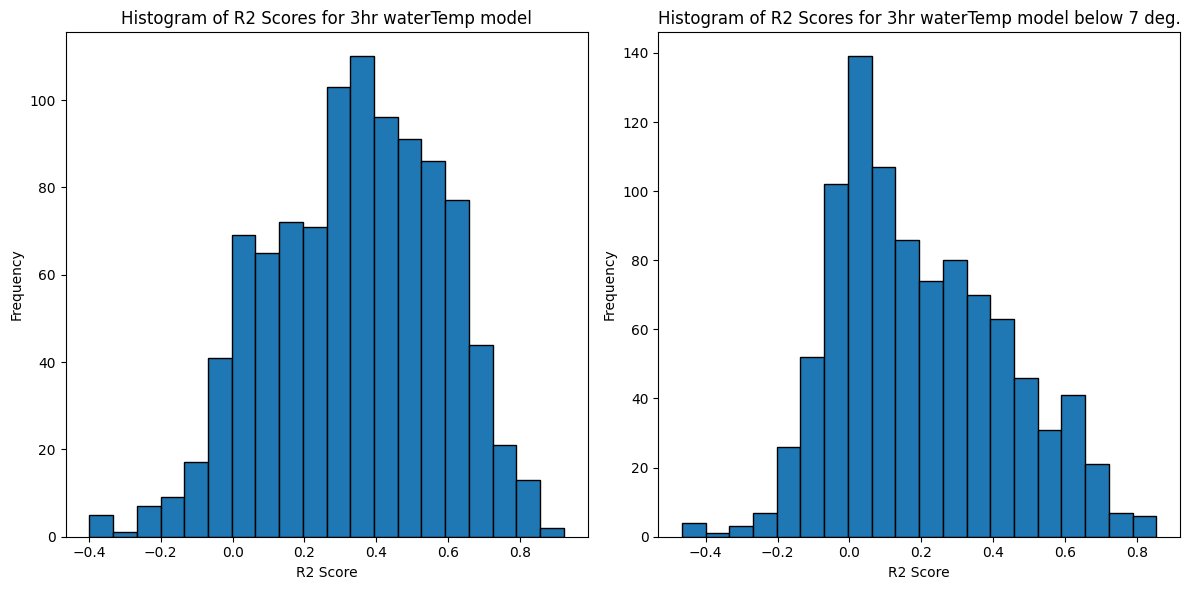

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(df_cic_models['WaterTemp_3hr_R2'], bins=20, edgecolor='black')
axs[0].set_xlabel('R2 Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of R2 Scores for 3hr waterTemp model')

axs[1].hist(df_cic_models['WaterTemp_3hr_filt_R2'], bins=20, edgecolor='black')
axs[1].set_xlabel('R2 Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of R2 Scores for 3hr waterTemp model below 7 deg.')

plt.tight_layout()
plt.show()


(array([  1.,   0.,   0.,   2.,   0.,   0.,   4.,   9.,  22.,  88., 294.,
        392., 470., 556., 675., 664., 568., 380., 154.,  32.]),
 array([-1.08964432, -0.98907877, -0.88851323, -0.78794769, -0.68738214,
        -0.5868166 , -0.48625106, -0.38568552, -0.28511997, -0.18455443,
        -0.08398889,  0.01657666,  0.1171422 ,  0.21770774,  0.31827328,
         0.41883883,  0.51940437,  0.61996991,  0.72053546,  0.821101  ,
         0.92166654]),
 <BarContainer object of 20 artists>)

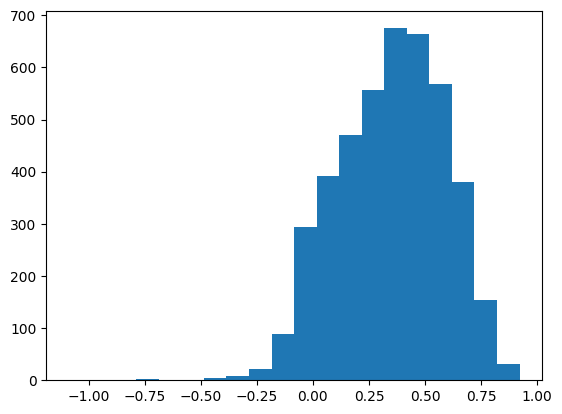

In [248]:
plt.hist(df_cic_models['WaterTemp_3hr_R2'], bins=20)

In [227]:
mean_R2_by_id = df_merged.groupby('3duo_id')[['WaterTemp_3hr_R2', 'Q_house_3hr_R2', 'WaterTemp_24hr_R2', 'Q_house_24hr_R2']].median()
print(mean_R2_by_id)

         WaterTemp_3hr_R2  Q_house_3hr_R2  WaterTemp_24hr_R2  Q_house_24hr_R2
3duo_id                                                                      
1.0              0.224591        0.368892           0.229165         0.621169
3.0              0.330692        0.470092           0.350018         0.662503
4.0              0.378360        0.505955           0.359099         0.673412
11.0             0.337149        0.468504           0.335396         0.638331
12.0             0.431072        0.533334           0.423034         0.675154


In [260]:
mean_R2_by_id = df_merged.groupby('3duo_id')[['WaterTemp_3hr_R2', 'Q_house_3hr_R2', 'WaterTemp_24hr_R2', 'Q_house_24hr_R2']].mean()
print(mean_R2_by_id)

         WaterTemp_3hr_R2  Q_house_3hr_R2  WaterTemp_24hr_R2  Q_house_24hr_R2
3duo_id                                                                      
1.0              0.247840        0.355508           0.262356         0.577986
3.0              0.328590        0.453510           0.340115         0.626800
4.0              0.343744        0.478799           0.341458         0.634452
11.0             0.329728        0.461659           0.330177         0.611364
12.0             0.418465        0.510933           0.405764         0.640544


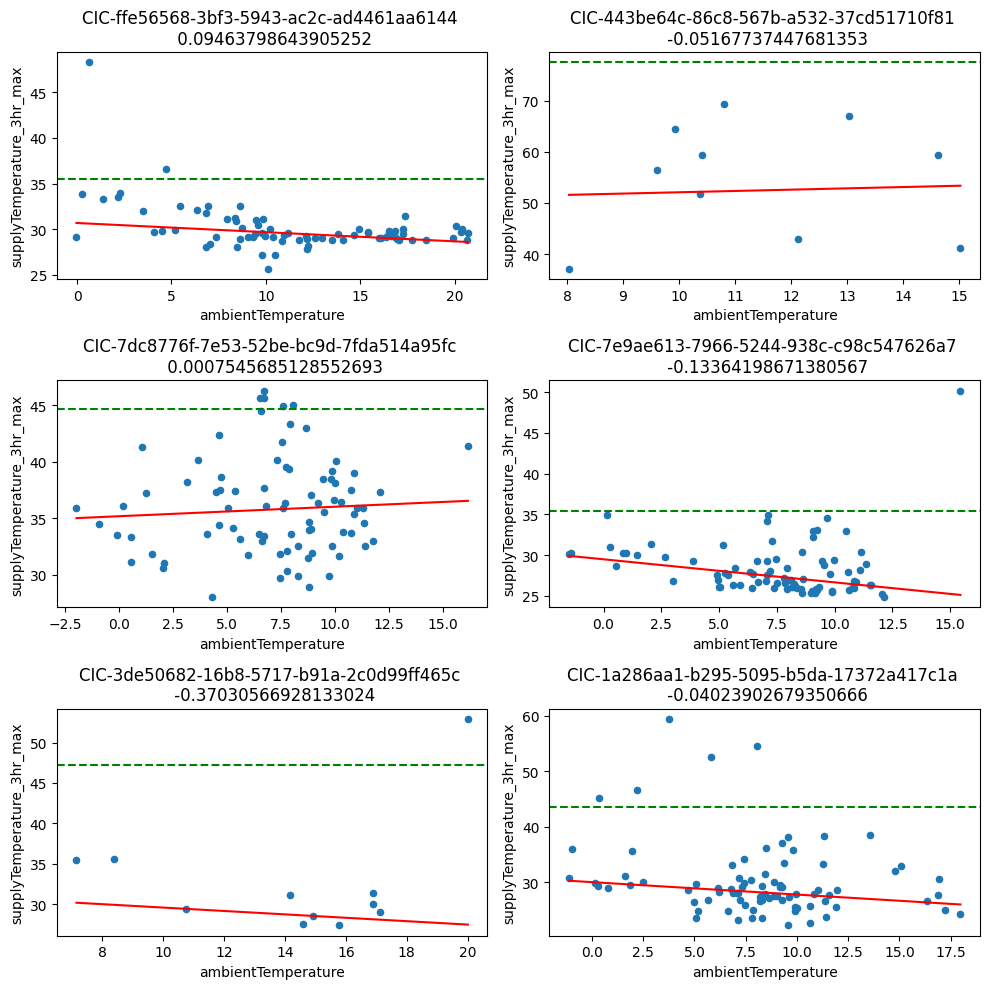

In [250]:
cics = df_merged[(df_merged['WaterTemp_3hr_R2']<0.1) &
                 (df_merged['3single_id']==1)
                 ]['cic_id'].unique()

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cic]
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature_3hr_max', ax=axs[i], label=cic)
    axs[i].set_title(f"{cic} \n {df_cic_models[df_cic_models['cic_id'] == cic]['WaterTemp_3hr_R2'].values[0]}")
    axs[i].get_legend().remove()
    # add line based on linear regression model
    x = np.linspace(df_cic['ambientTemperature'].min(), df_cic['ambientTemperature'].max(), 100)
    y = df_cic_models[df_cic_models['cic_id'] == cic]['WaterTemp_3hr_slope'].values[0] * x + df_cic_models[df_cic_models['cic_id'] == cic]['WaterTemp_3hr_intercept'].values[0]
    axs[i].plot(x, y, '-r')
    # horizontal line
    axs[i].axhline(y=df_cic['supplyTemperature_3hr_max'].mean() + 2 * df_cic['supplyTemperature_3hr_max'].std(),
                   color='green', linestyle='--')
    

plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()

array([[<Axes: xlabel='WaterTemp_3hr', ylabel='WaterTemp_3hr'>,
        <Axes: xlabel='WaterTemp_3hr_R2', ylabel='WaterTemp_3hr'>,
        <Axes: xlabel='Q_house_3hr', ylabel='WaterTemp_3hr'>,
        <Axes: xlabel='Q_house_3hr_R2', ylabel='WaterTemp_3hr'>],
       [<Axes: xlabel='WaterTemp_3hr', ylabel='WaterTemp_3hr_R2'>,
        <Axes: xlabel='WaterTemp_3hr_R2', ylabel='WaterTemp_3hr_R2'>,
        <Axes: xlabel='Q_house_3hr', ylabel='WaterTemp_3hr_R2'>,
        <Axes: xlabel='Q_house_3hr_R2', ylabel='WaterTemp_3hr_R2'>],
       [<Axes: xlabel='WaterTemp_3hr', ylabel='Q_house_3hr'>,
        <Axes: xlabel='WaterTemp_3hr_R2', ylabel='Q_house_3hr'>,
        <Axes: xlabel='Q_house_3hr', ylabel='Q_house_3hr'>,
        <Axes: xlabel='Q_house_3hr_R2', ylabel='Q_house_3hr'>],
       [<Axes: xlabel='WaterTemp_3hr', ylabel='Q_house_3hr_R2'>,
        <Axes: xlabel='WaterTemp_3hr_R2', ylabel='Q_house_3hr_R2'>,
        <Axes: xlabel='Q_house_3hr', ylabel='Q_house_3hr_R2'>,
        <Axes: xlabel='

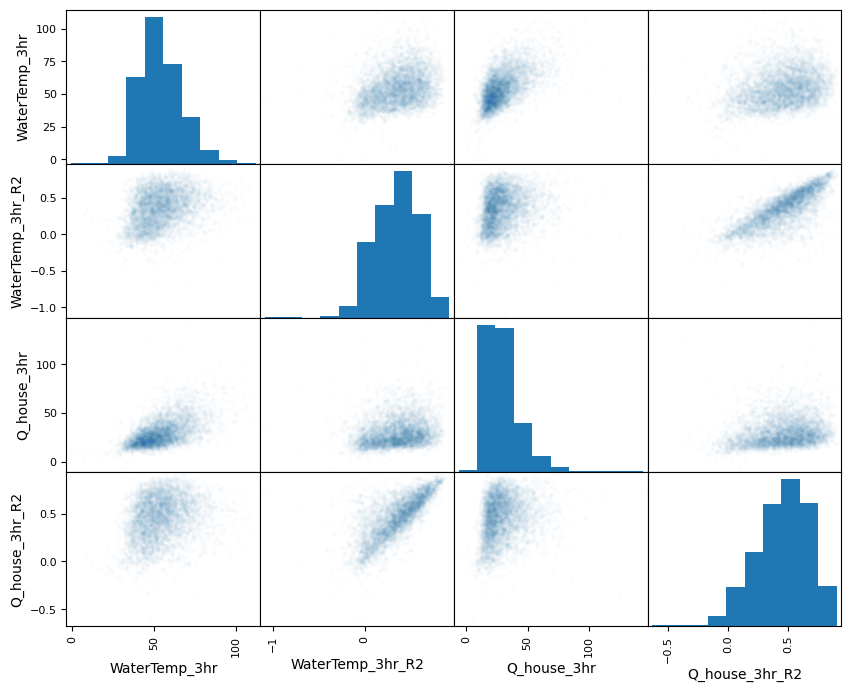

In [264]:
scatter_cols = ['WaterTemp_3hr', 'WaterTemp_3hr_R2', 'Q_house_3hr', 'Q_house_3hr_R2']
scatter_matrix(df_merged[scatter_cols], figsize=(10, 8), alpha=0.02)

In [ ]:
# Mark outliers for determining heat demand curve and supply temperature curve

# per cic mark water outliers and 
# df_cics['water_outlier'] = 0
# df_cics['heat_outlier'] = 0

# # errors during outlier detection
# errors = []


# for cic in df_cics['cic_id'].unique():
#     df_cic = df_cics[df_cics['cic_id'] == cic]

#     try: 
#         X = df_cic[['Q_hp', 'Q_house']].to_numpy()
#         model = CD(contamination=FWFM())
#         model.fit(X)
#         y_pred = model.predict(X)
#         # set y-pred back into original df
#         df_cics.loc[df_cics['cic_id'] == cic,'heat_outlier'] = y_pred
#     except ValueError:
#         errors.append(cic)
#         pass
    
    # try: 
    #     X = df_cic[['ambientTemperature', 'supplyTemperature']].to_numpy()
    #     model = CD(contamination=FWFM())
    #     model.fit(X)
    #     y_pred = model.predict(X)
    #     df_cics.loc[df_cics['cic_id'] == cic,'water_outlier'] = y_pred
    # except ValueError:
    #     pass

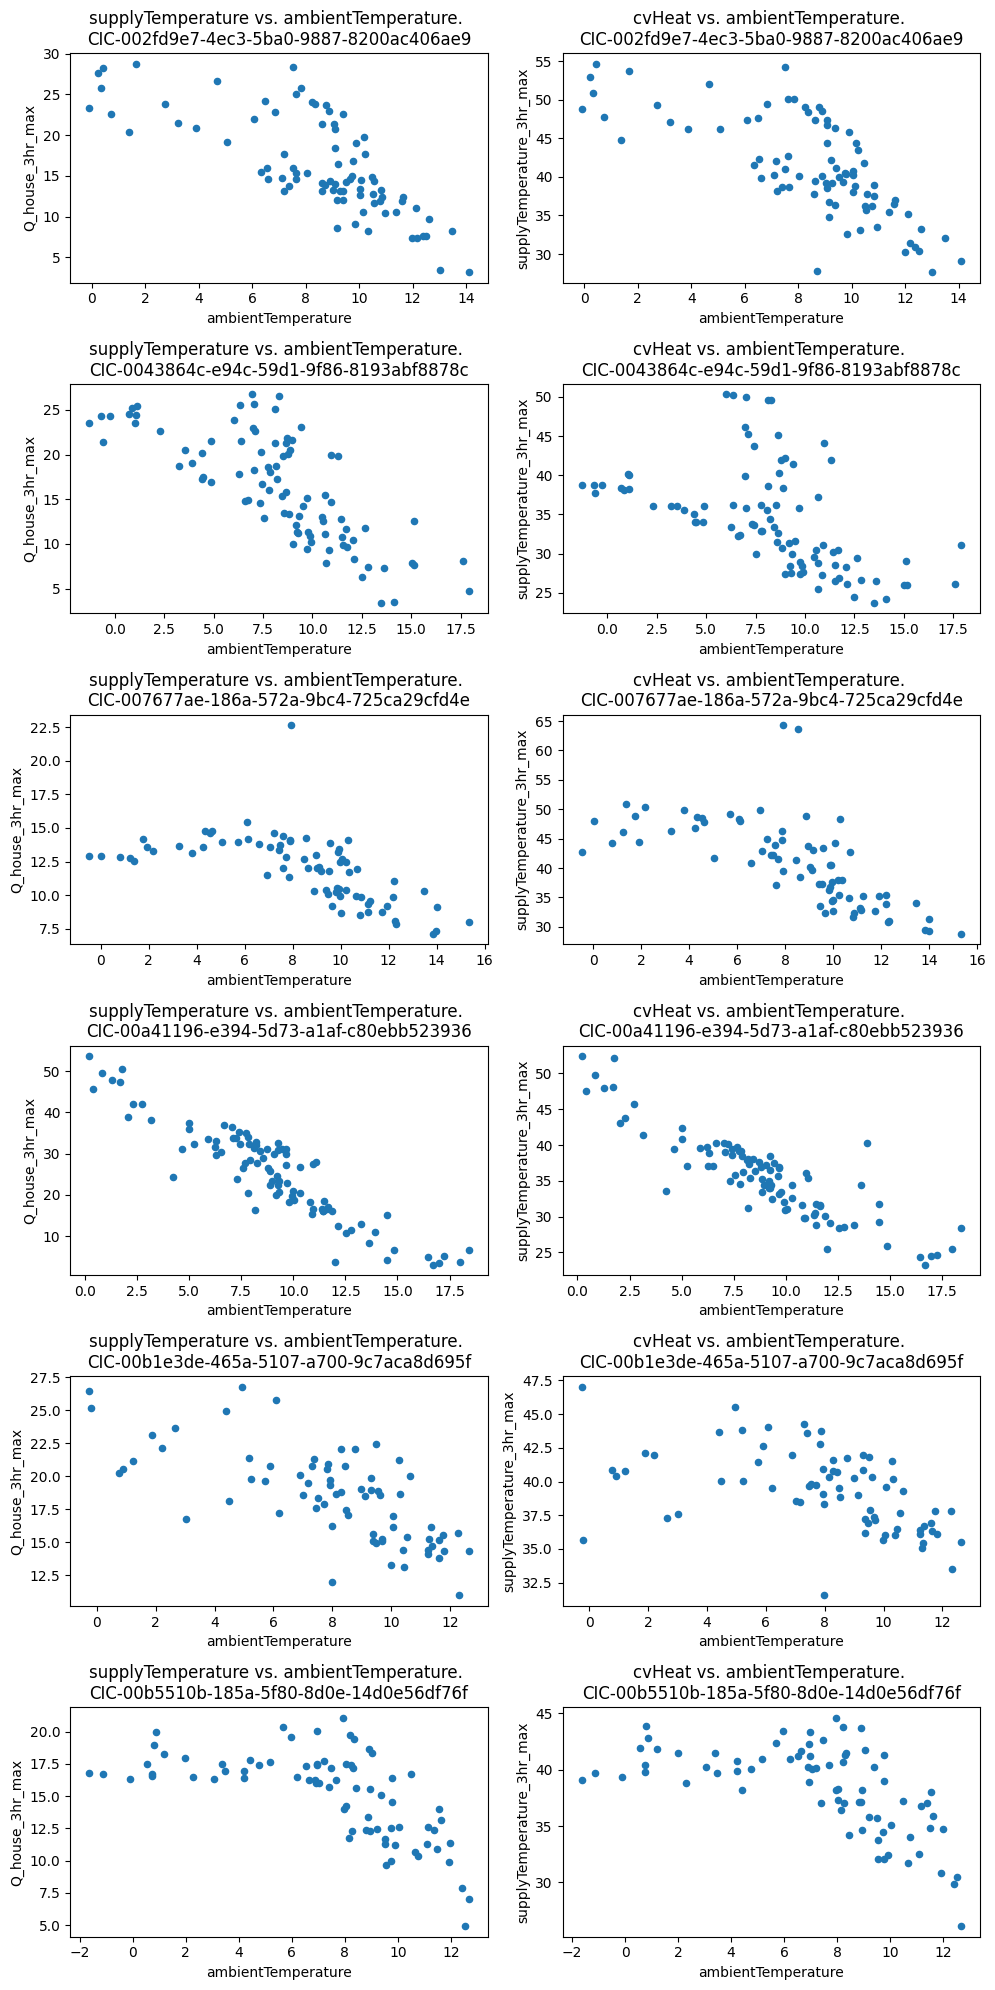

In [ ]:
# plot supplyTemperature vs. ambientTemperature for several cic's
import seaborn as sns
import matplotlib.pyplot as plt
cics = df_cics['cic_id'].unique()

fig, axs = plt.subplots(6, 2, figsize=(10, 20))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cics[i+6]]
    df_cic.plot(kind='scatter', x='ambientTemperature', y='Q_house_3hr_max', 
                # c='heat_outlier', cmap='jet', 
                ax=axs[i*2], label=cic)
    axs[i*2].set_title(f'supplyTemperature vs. ambientTemperature. \n{cic}')
    axs[i*2].get_legend().remove()

    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature_3hr_max', 
                 ax=axs[i*2+1], label=cic)
    axs[i*2+1].set_title(f'cvHeat vs. ambientTemperature. \n{cic}')
    axs[i*2+1].get_legend().remove()
    # axs[i].collections[0].colorbar.remove()


plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()



# fig = go.Figure()
# for cic in cics[:5]:
#     df_cic = df_cics[df_cics['cic_id'] == cic]
#     fig.add_trace(go.Scatter(x=df_cic['ambientTemperature'], y=df_cic['supplyTemperature'], mode='markers', name=cic))
# fig.update_layout(title='supplyTemperature vs. ambientTemperature for several cic\'s')
# fig.show()

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_86852/2465185769.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic['residuals'] = abs(df_cic['supplyTemperature_3hr_max'] - model.predict(df_cic[['ambientTemperature']]))
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_86852/2465185769.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic['residuals_rel'] = df_cic['residuals'] / df_cic['residuals'].std()
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_86852/2465

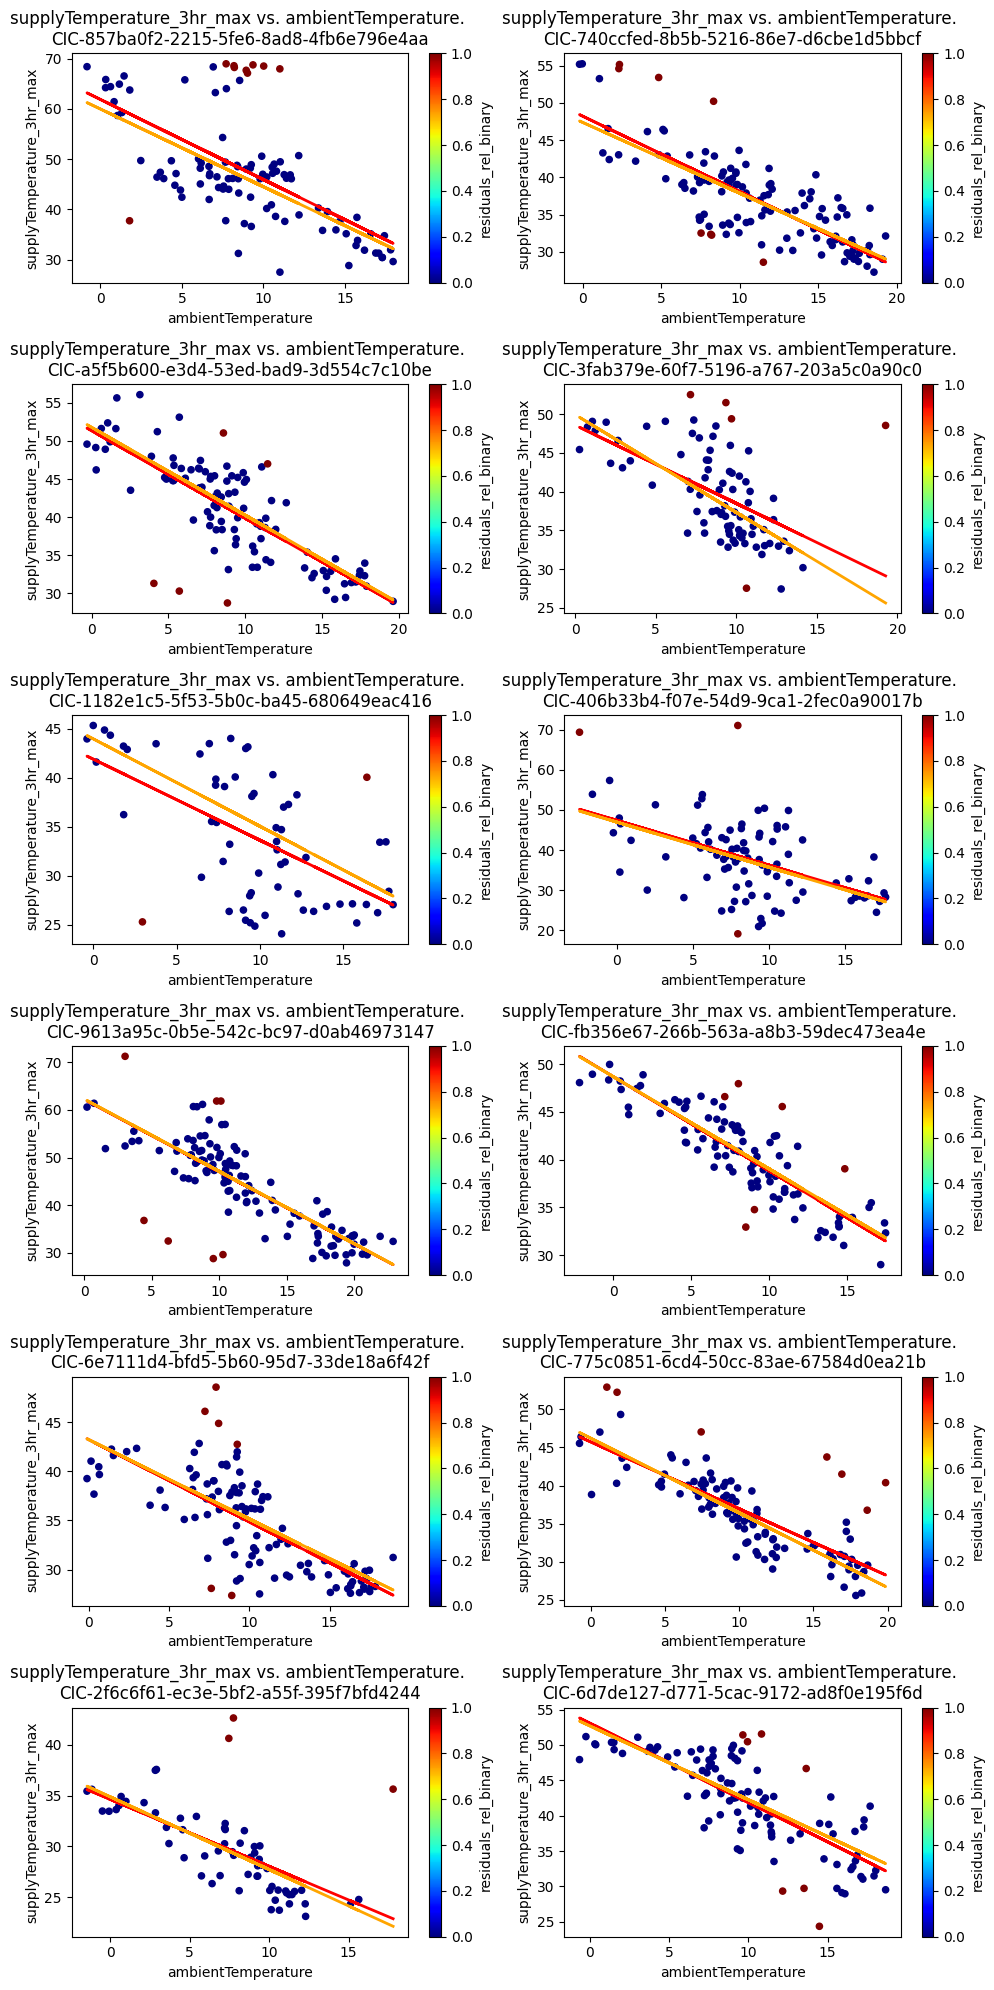

In [ ]:
cics = df_cics['cic_id'].unique()
model = LinearRegression()

fig, axs = plt.subplots(6, 2, figsize=(10, 20))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:12]):  # Change the slice to select the first 6 cics
    i+12
    df_cic = df_cics[df_cics['cic_id'] == cic]


    model.fit(df_cic[['ambientTemperature']], df_cic['supplyTemperature_3hr_max'])
    # absoluate error
    df_cic['residuals'] = abs(df_cic['supplyTemperature_3hr_max'] - model.predict(df_cic[['ambientTemperature']]))
    df_cic['residuals_rel'] = df_cic['residuals'] / df_cic['residuals'].std()
    df_cic['residuals_rel_binary'] = np.where(df_cic['residuals_rel'] > 3, 1, 0)
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature_3hr_max',
                c='residuals_rel_binary', cmap='jet', ax=axs[i], label=cic)
    
    # plot linear regression line
    axs[i].plot(df_cic['ambientTemperature'], model.predict(df_cic[['ambientTemperature']]), color='red', linewidth=2)

    TSModel = TheilSenRegressor(random_state=0).fit(df_cic[['ambientTemperature']], df_cic['supplyTemperature_3hr_max'])
    axs[i].plot(df_cic['ambientTemperature'], TSModel.predict(df_cic[['ambientTemperature']]), color='orange', linewidth=2)

    if TSModel.coef_ > 0:
        axs[i].axhline(y=df_cic['supplyTemperature_3hr_max'].quantile(0.8), color='green', linestyle='--')

    axs[i].set_title(f'supplyTemperature_3hr_max vs. ambientTemperature. \n{cic}')
    axs[i].get_legend().remove()
    # axs[i].collections[0].colorbar.remove()


plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()


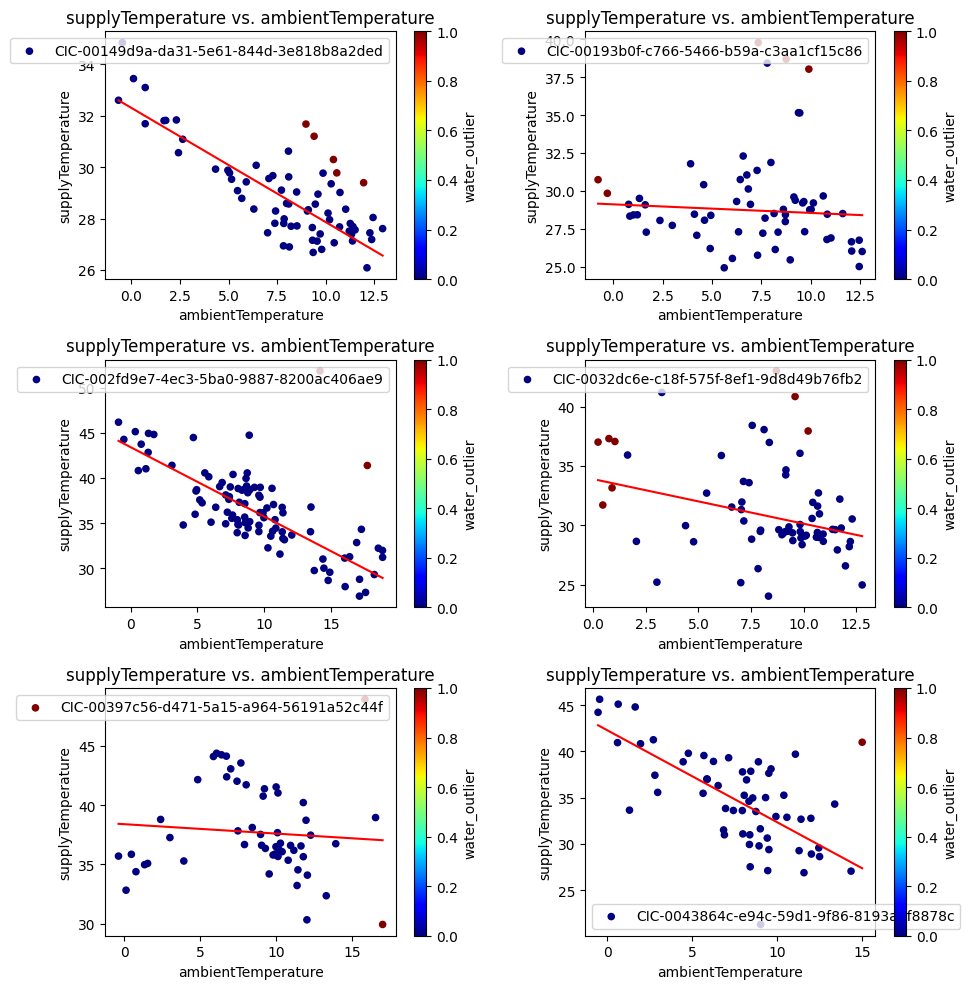

In [ ]:
# plot supplyTemperature vs. ambientTemperature for several cic's using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
cics = df_cics['cic_id'].unique()

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cic]
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature', 
                c='water_outlier', cmap='jet', ax=axs[i], label=cic)
    axs[i].set_title(f'supplyTemperature vs. ambientTemperature')
    # axs[i].set_suptitle(cic)
    axs[i].legend()
    # add line based on linear regression model
    x = np.linspace(df_cic['ambientTemperature'].min(), df_cic['ambientTemperature'].max(), 100)
    y = df_cics_train[df_cics_train['cic_id'] == cic]['water_slope'].values[0] * x + df_cics_train[df_cics_train['cic_id'] == cic]['water_intercept'].values[0]
    axs[i].plot(x, y, '-r')

plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()



array([[<Axes: title={'center': 'WaterTemp_3hr'}>,
        <Axes: title={'center': 'supplyTemperature_3hr_max'}>]],
      dtype=object)

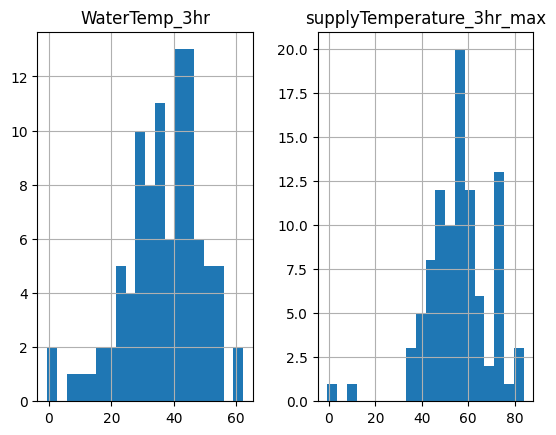

In [ ]:


df_merged[df_merged['WaterTemp_3hr_slope']>0][['WaterTemp_3hr','supplyTemperature_3hr_max']].hist(bins=20)